dt vs rf vs gb: https://www.datasciencecentral.com/profiles/blogs/decision-tree-vs-random-forest-vs-boosted-trees-explained
     rf hyper tune: https://medium.com/all-things-ai/in-depth-parameter-tuning-for-random-forest-d67bb7e920d
partial dependency: https://scikit-learn.org/stable/auto_examples/inspection/plot_partial_dependence.html#sphx-glr-auto-examples-inspection-plot-partial-dependence-py


# Load data from csv files

In [70]:
import pandas as pd

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV

import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.utils.multiclass import unique_labels

from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence

# Supperess convergence warnings
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

In [2]:
# Read data from csv files
label = pd.read_csv('BurnedArea-100k.csv')
elevation = pd.read_csv('Elevation-100k.csv')
forest = pd.read_csv('Forest-100k.csv')
humanMod = pd.read_csv('HumanModification-100k.csv')
leaf = pd.read_csv('LeafArea-100k.csv')
rain = pd.read_csv('Precipitation-100k.csv')
radiation = pd.read_csv('Radiation-100k.csv')
soil = pd.read_csv('SoilType-100k.csv')
temp = pd.read_csv('Temperature-100k.csv')

In [3]:
# Merge all dataframes via inner join
samples = pd.merge(left=elevation, right=forest, left_on='system:index', right_on='system:index')
samples = pd.merge(left=samples, right=humanMod, left_on='system:index', right_on='system:index')
samples = pd.merge(left=samples, right=leaf, left_on='system:index', right_on='system:index')
samples = pd.merge(left=samples, right=rain, left_on='system:index', right_on='system:index')
samples = pd.merge(left=samples, right=radiation, left_on='system:index', right_on='system:index')
samples = pd.merge(left=samples, right=soil, left_on='system:index', right_on='system:index')
samples = pd.merge(left=samples, right=temp, left_on='system:index', right_on='system:index')

fireIdx = label.copy()
del fireIdx['BurnDate']
del fireIdx['FirstDay']
del fireIdx['LastDay']
del fireIdx['QA']
del fireIdx['BurnMonth']

In [60]:
# Label samples
samplesCopy = samples.copy()
samplesCopy = pd.merge(left=fireIdx, right=samplesCopy, how='right', left_on='system:index', right_on='system:index')

sampleLabel = samplesCopy['Uncertainty'].fillna(100).tolist()
firstNoFireIdx = sampleLabel.index(100)

# Drop label column
del samplesCopy['Uncertainty']
# Drop system index
del samplesCopy['system:index']
samplesList = samplesCopy.values.tolist()
# Filter out fire samples
fireSamples = samplesList[:firstNoFireIdx]
fireUncertain = sampleLabel[:firstNoFireIdx]
# Filter out no fire samples
noFireSamples = samplesList[firstNoFireIdx:]
noFireLabel = [0 for _ in range(len(noFireSamples))]

# Split the training datasets
X_train_fire, X_test_fire, y_train_fire, y_test_fire = train_test_split(fireSamples, fireUncertain, test_size=0.2, random_state=0)
X_train_nofire, X_test_nofire, y_train_nofire, y_test_nofire = train_test_split(noFireSamples, noFireLabel, test_size=0.9, random_state=42)

# Relabling for binary classification
y_train_fire_bool = [1 for _ in range(len(y_train_fire))]
y_test_fire_bool = [1 for _ in range(len(y_test_fire))]
X_train = X_train_fire + X_train_nofire
y_train = y_train_fire_bool + y_train_nofire
X_test = X_test_fire + X_test_nofire
y_test = y_test_fire_bool + y_test_nofire

# Normalize datasets
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.fit_transform(X_test)
X_train_fire_norm = scaler.fit_transform(X_train_fire)
X_test_fire_norm = scaler.fit_transform(X_test_fire)
X_test_nofire_norm = scaler.fit_transform(X_test_nofire)

# Binary Classification

## Logistic Regression

In [90]:
lr_fnf = LogisticRegression(solver='sag', penalty='l2', class_weight={0:.1, 1:.9}, random_state=0, n_jobs=-1)
lr_fnf = lr_fnf.fit(X_train_norm, y_train)

fire prediction:  0.27488151658767773
nofire prediction:  0.7638438757264193


C:\Users\Yi\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [91]:
# Used for pipeline
y_pred_lr_fire_bool = lr_fnf.predict(X_test_fire_norm)

y_pred_lr_fnf = lr_fnf.predict(X_test_norm)
print(classification_report(y_test, y_pred_lr_fnf))

fire prediction:  0.27488151658767773
nofire prediction:  0.7638438757264193
              precision    recall  f1-score   support

           0       1.00      0.77      0.87     71584
           1       0.01      0.82      0.02       211

    accuracy                           0.77     71795
   macro avg       0.50      0.79      0.44     71795
weighted avg       1.00      0.77      0.86     71795



## Decision Tree

In [92]:
# 'class_weight': {0: 1.5, 1: 8.5}, 'max_depth': 2, 'max_features': 0.1, 'min_samples_leaf': 5, 'min_samples_split': 0.3
# Specify class_weight to adjust bias
dt_fnf = DecisionTreeClassifier(max_depth=5, min_samples_split=0.2, min_samples_leaf=5, max_features=0.1, class_weight={0:1.5, 1:8.5}, random_state=20)
dt_fnf = dt_fnf.fit(X_train, y_train)

In [93]:
# Used for pipeline
y_pred_dt_fire_bool = dt_fnf.predict(X_test_fire)

y_pred_dt_fnf = dt_fnf.predict(X_test)
print(classification_report(y_test, y_pred_dt_fnf))

fire prediction:  0.7298578199052133
nofire prediction:  0.7174368573983013
              precision    recall  f1-score   support

           0       1.00      0.72      0.84     71584
           1       0.01      0.73      0.01       211

    accuracy                           0.72     71795
   macro avg       0.50      0.72      0.43     71795
weighted avg       1.00      0.72      0.83     71795



## Random Forest

In [94]:
# Train RandomForest
rf_fnf = RandomForestClassifier(n_estimators=20, max_depth=20, min_samples_leaf=1, max_features=19, min_samples_split=3, random_state=20, n_jobs=-1)
rf_fnf = rf_fnf.fit(X_train, y_train)

fire prediction:  0.7582938388625592
nofire prediction:  0.9918417523468932


In [104]:
# Used for pipeline
y_pred_rf_fire_bool = rf_fnf.predict(X_test_fire)

y_pred_rf_fnf = rf_fnf.predict(X_test)
print(classification_report(y_test, y_pred_rf_fnf))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     71584
           1       0.22      0.76      0.34       211

    accuracy                           0.99     71795
   macro avg       0.61      0.88      0.67     71795
weighted avg       1.00      0.99      0.99     71795



## Gradient Boosting

In [133]:
# estimators 3000: learning_rate=0.1,max_depth=8,max_features=0.3,min_samples_leaf=17,
# estimators 5000: learning_rate=0.02,max_depth=6,max_features=0.1,min_samples_leaf=9,  -- fire prediction:  0.8341232227488151  nofire prediction:  0.99159029950827
# deviance plot shows that larger estimators (iterations) don't improve score
gb_fnf = GradientBoostingClassifier(n_estimators=400, max_depth=8, learning_rate=0.1, min_samples_leaf=17, max_features=0.3, random_state=20)
gb_fnf = gb_fnf.fit(X_train, y_train)

In [109]:
# Used for pipeline
y_pred_gb_fire_bool = gb_fnf.predict(X_test_fire)

y_pred_gb_fnf = gb_fnf.predict(X_test)
print(classification_report(y_test, y_pred_gb_fnf))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      9789
           1       0.66      0.83      0.73       211

    accuracy                           0.99     10000
   macro avg       0.83      0.91      0.86     10000
weighted avg       0.99      0.99      0.99     10000



## Gaussian Process Classification

In [59]:
kernel = 1.0 * RBF(1.0)
gpc_fnf = GaussianProcessClassifier(kernel=kernel, random_state=0)
gpc_fnf = gpc_fnf.fit(X_train_norm, y_train)

fire prediction:  0.4834123222748815


NameError: name 'X_test_nofire_norm' is not defined

In [108]:
# Used for pipeline
y_pred_fire_bool = gpc_fnf.predict(X_test_fire_norm)

y_pred_gpc_fnf = gpc_fnf.predict(X_test_norm[:10000])
print(classification_report(y_test[:10000], y_pred_gpc_fnf))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      9789
           1       0.52      0.79      0.63       211

    accuracy                           0.98     10000
   macro avg       0.76      0.89      0.81     10000
weighted avg       0.99      0.98      0.98     10000



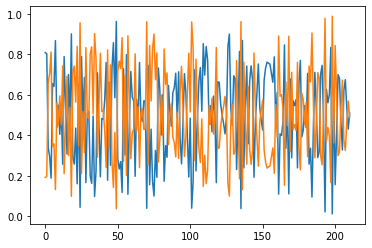

In [65]:
plt.plot(gpc_fnf.predict_proba(X_test_fire_norm))

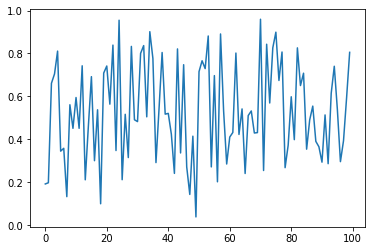

In [69]:
plt.plot(gpc_fnf.predict_proba(X_test_fire_norm[:100])[:, 1])

## FnF Importance Distribution

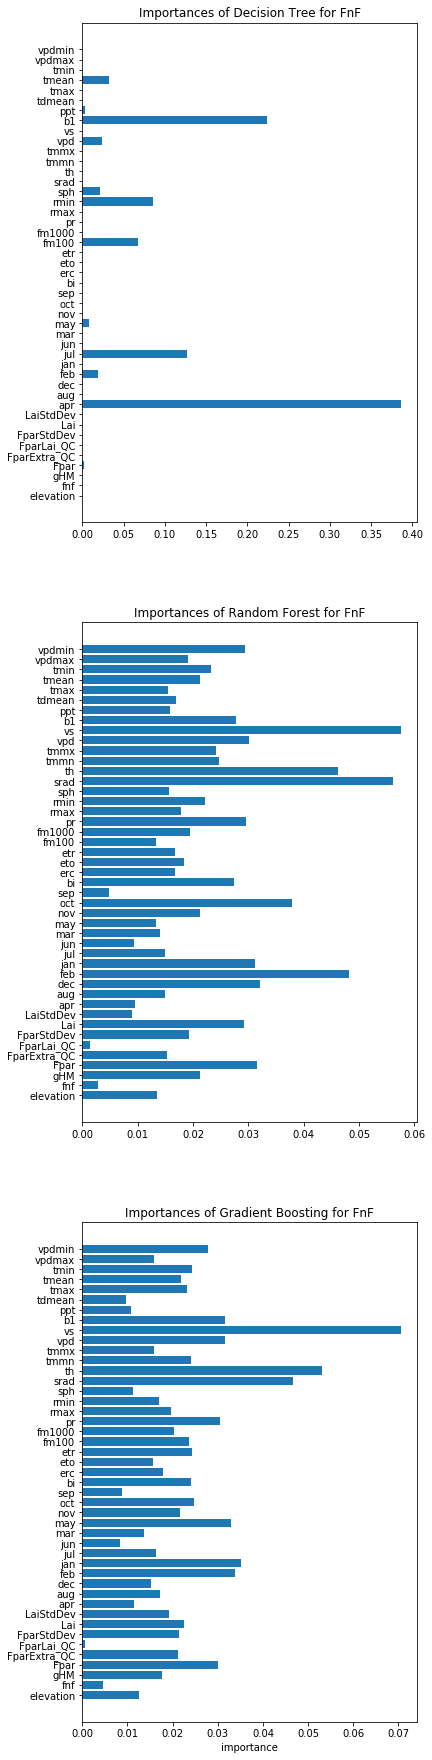

In [25]:
fnf_features = samplesCopy.columns
y_pos = np.arange(len(fnf_features))

fig = plt.figure()

dt_fnf_importances = dt_fnf.feature_importances_
ax1 = fig.add_subplot(311)
ax1.barh(y_pos, dt_fnf_importances)
ax1.set_yticks(y_pos)
ax1.set_yticklabels(fnf_features)
ax1.set_title('Importances of Decision Tree for FnF')

rf_fnf_importances = rf_fnf.feature_importances_
ax2 = fig.add_subplot(312)
ax2.barh(y_pos, rf_fnf_importances)
ax2.set_yticks(y_pos)
ax2.set_yticklabels(fnf_features)
ax2.set_title('Importances of Random Forest for FnF')

gb_fnf_importances = gb_fnf.feature_importances_
ax3 = fig.add_subplot(313)
ax3.barh(y_pos, gb_fnf_importances)
ax3.set_yticks(y_pos)
ax3.set_yticklabels(fnf_features)
ax3.set_title('Importances of Gradient Boosting for FnF')
ax3.set(xlabel='importance')


plt.subplots_adjust(bottom=.1, top=6)
plt.show()

## FnF Partial Dependencies

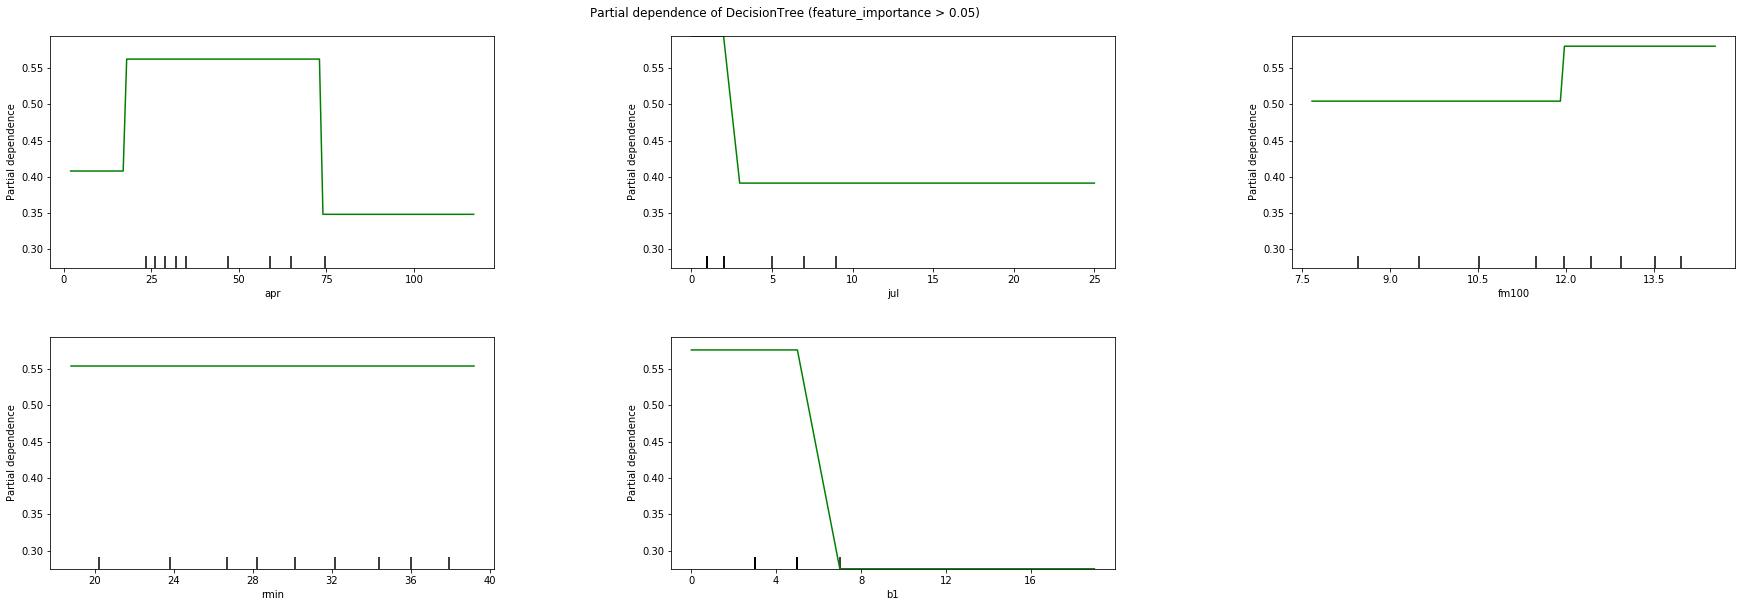

In [237]:
# 9, 14, 25, 29, 37
plot_partial_dependence(dt_fnf, X=X_train_fire, features=[9, 14, 25, 29, 37], feature_names=fnf_features, n_jobs=-1)
fig = plt.gcf()
fig.suptitle('Partial dependence of DecisionTree (feature_importance > 0.05)', x=1.8, y=2.1)
plt.subplots_adjust(top=2, right=4)

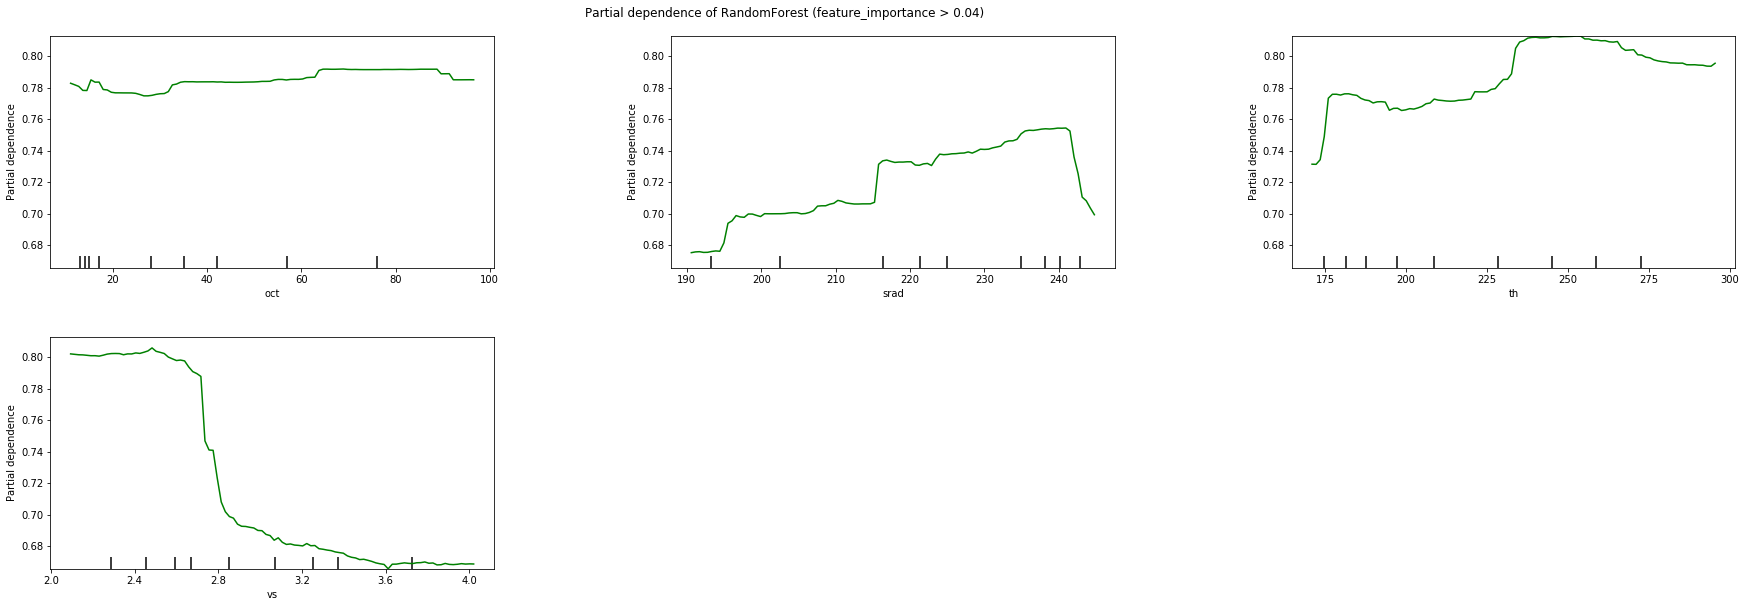

In [113]:
# 19, 31, 32, 36
# Prediction is very slow
plot_partial_dependence(rf_fnf, X=X_train_fire, features=[19, 31, 32, 36], feature_names=fnf_features, n_jobs=-1)
fig = plt.gcf()
fig.suptitle('Partial dependence of RandomForest (feature_importance > 0.04)', x=1.8, y=2.1)
plt.subplots_adjust(top=2, right=4)

Text(0.5, 0.98, 'Partial dependence of RandomForest (feature_importance > 0.04)')

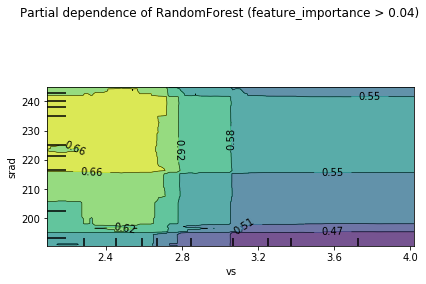

In [26]:
# 19, 31, 32, 36
# Prediction is very slow  (36, 32),
plot_partial_dependence(rf_fnf, X=X_train_fire, features=[(36, 31)], feature_names=fnf_features, n_jobs=-1)
fig = plt.gcf()
fig.suptitle('Partial dependence of RandomForest (feature_importance > 0.04)')
#plt.subplots_adjust(top=2, right=4)

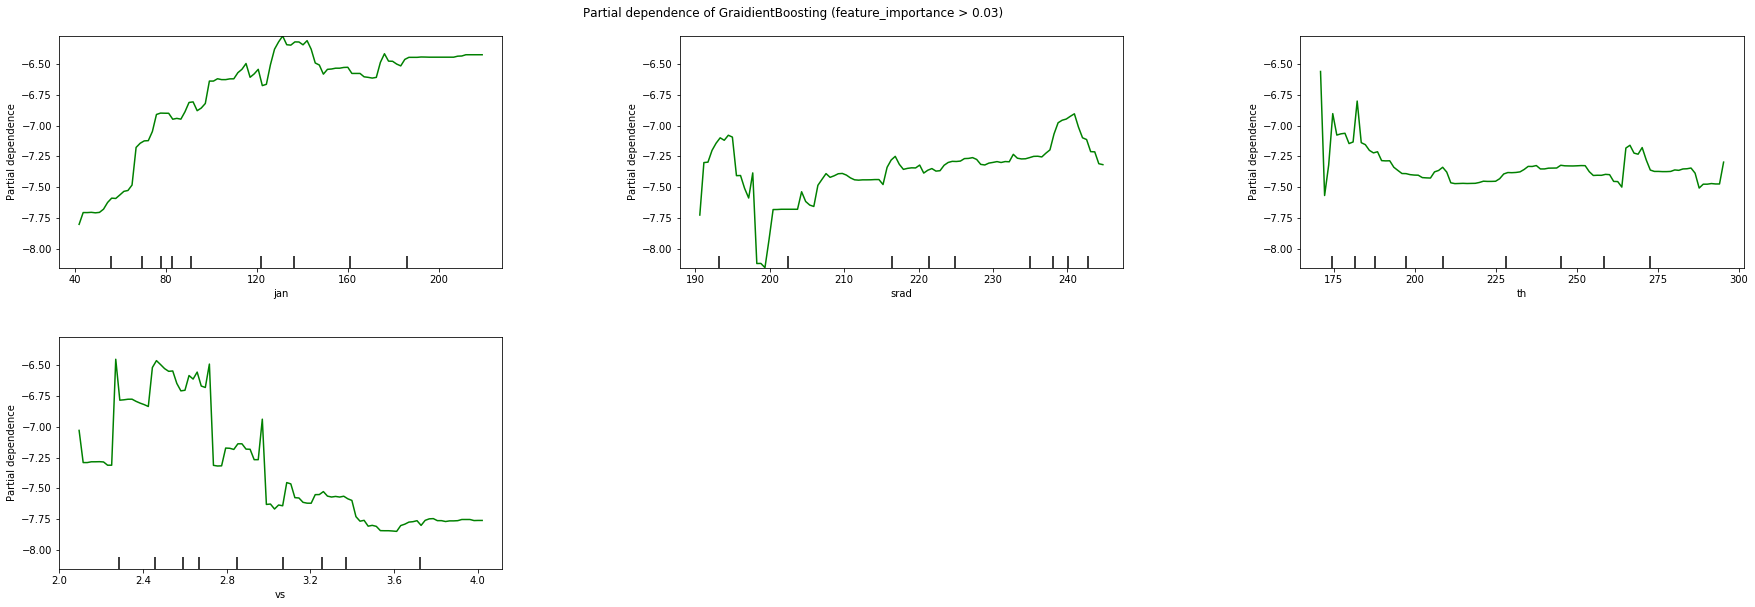

In [179]:
# 12, 13, 32, 35, 36, 41
plot_partial_dependence(gb_fnf, X=X_train_fire, features=[13, 31, 32, 36], feature_names=fnf_features, n_jobs=-1)
fig = plt.gcf()
fig.suptitle('Partial dependence of GraidientBoosting (feature_importance > 0.035)', x=1.8, y=2.1)
plt.subplots_adjust(top=2, right=4)

Text(0.5, 0.98, 'Partial dependence of GraidientBoosting (feature_importance > 0.035)')

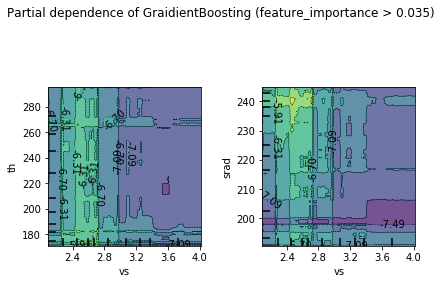

In [152]:
# https://scikit-learn.org/stable/auto_examples/inspection/plot_partial_dependence.html#sphx-glr-auto-examples-inspection-plot-partial-dependence-py
# (36, 41)
plot_partial_dependence(gb_fnf, X=X_train_fire, features=[(36, 32), (36,31)], feature_names=fnf_features, n_jobs=-1)
fig = plt.gcf()
fig.suptitle('Partial dependence of GraidientBoosting (feature_importance > 0.035)')
#plt.subplots_adjust(top=2, right=4)

In [178]:
for i, _ in enumerate(gb_fnf.feature_importances_):
    if _ > 0.035:
        print(i)

13
31
32
36


# Confusion Matrix for Binary Classification

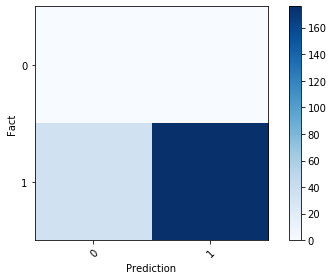

In [186]:
#yy_test = y_test_fire_bool + y_test_nofire
#yy_pred = np.append(y_pred_fire_bool, y_no_fire_pred)
yy_test = y_test_fire_bool# + y_test_nofire
yy_pred = y_pred_fire_bool#, y_no_fire_pred)
cm = confusion_matrix(yy_test, yy_pred)

# Only uses the labels that appear in the data
labels = unique_labels(yy_test, yy_pred)
#print(cm)

fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=labels, yticklabels=labels,
           ylabel='Fact',
           xlabel='Prediction')
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
fig.tight_layout()

## Train Error vs Test Error

In [191]:
est_n = range(10, 3000, 100)
train_errs = list()
test_errs = list()
for est in est_n:
    rf_fnf.set_params(n_estimators=est)
    rf_fnf.fit(X_train, y_train)
    train_errs.append(rf_fnf.score(X_train, y_train))
    test_errs.append(rf_fnf.score(X_test, y_test))

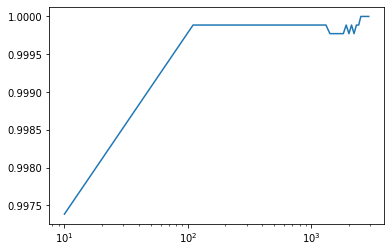

In [193]:
plt.semilogx(est_n, train_errs, label='Train')
#plt.semilogx(est_n, test_errs, label='Test')

In [205]:
est_log = np.logspace(0, 3.5, 30)
est_log = unique_labels(list(map(int, est_log)))
train_errs_fnf = list()
test_errs_fnf = list()
for est in est_log:
    rf_fnf.set_params(n_estimators=est)
    rf_fnf.fit(X_train, y_train)
    train_errs_fnf.append(rf_fnf.score(X_train_fire, y_train_fire_bool))
    test_errs_fnf.append(rf_fnf.score(X_test_fire, y_test_fire_bool))

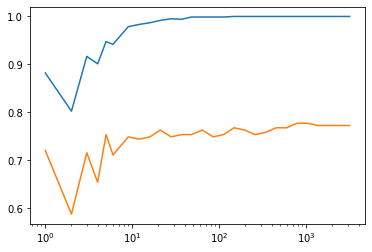

In [206]:
plt.semilogx(est_log, train_errs_fnf, label='Train')
plt.semilogx(est_log, test_errs_fnf, label='Test')

In [226]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, gb_fnf.predict(X_test))
print("MSE: %.4f" % mse)

MSE: 0.0091


Text(0, 0.5, 'Deviance')

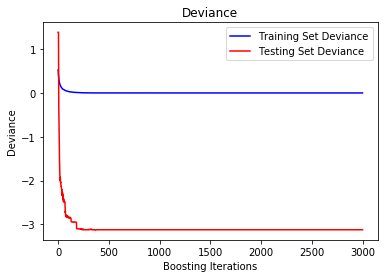

In [229]:
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html
# Deviance plot is to judge whether overfitting or underfitting
test_scores_fnf = [0 for _ in range(3000)]
for i, y_pred_fnf in enumerate(gb_fnf.staged_predict(X_test_fire)):
    test_scores_fnf[i] = gb_fnf.loss_(y_test_fire, y_pred_fnf)
plt.plot(np.arange(3000)+1, gb_fnf.train_score_, 'b-', label='Training Set Deviance')
plt.plot(np.arange(3000)+1, test_scores_fnf, 'r-', label='Testing Set Deviance')
plt.title('Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

In [13]:
# RandomForest
# Deviance plot is to judge whether overfitting or underfitting
test_scores_fnf = [0 for _ in range(1, 300)]
#train_scores_fnf = [0 for _ in range(1, 300)]
for i in range(1, 300):
    rf_fnf.set_params(n_estimators=i)
    test_scores_fnf[i] = rf_fnf.score(X_test_fire, y_test_fire)
 #   train_scores_fnf[i] = rf_fnf.score(X_test_fire, y_test_fire)
#plt.plot(np.arange(300)+1, train_scores_fnf, 'b-', label='Training Set Deviance')
print(test_score_fnf)
#plt.plot(np.arange(300), test_scores_fnf, 'r-', label='Testing Set Deviance')
#plt.title('Deviance')
#plt.legend(loc='upper right')
#plt.xlabel('Iterations')
#plt.ylabel('Deviance')

IndexError: list assignment index out of range

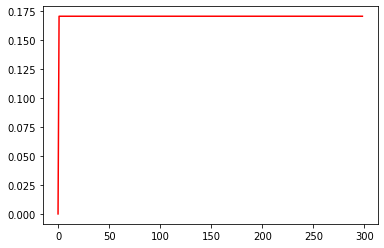

In [17]:
plt.plot(test_scores_fnf, 'r-', label='Testing Set Deviance')
#plt.title('Deviance')
#plt.legend(loc='upper right')
#plt.xlabel('Iterations')
#plt.ylabel('Deviance')

# Multi-Classification

## Logistic Regression

In [148]:
lr_risk = LogisticRegression(solver='newton-cg', penalty='l2', random_state=0, n_jobs=-1)
#lr_risk = LogisticRegression(solver='liblinear', penalty='l1', random_state=0, n_jobs=-1)
lr_risk = lr_risk.fit(X_train_fire_norm, y_train_fire)

C:\Users\Yi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Exact accuracy 0.23696682464454977
Accuracy diff < 6:  0.7725118483412322


In [129]:
y_pred_lr_risk = lr_risk.predict(X_test_fire)
print('Exact accuracy', np.mean((y_test_fire == y_pred_lr_risk) * y_pred_gb_fire_bool))
result = []
for i, true_val in enumerate(y_test_fire):
    if abs(true_val - y_pred_lr_risk[i]) < 6:
        result.append(1)
    else:
        result.append(0)
print('Accuracy diff < 6: ', np.mean(result * y_pred_gb_fire_bool))
print(classification_report(y_test_fire*y_pred_gb_fire_bool, y_pred_lr_risk*y_pred_gb_fire_bool))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        35
         1.0       0.00      0.00      0.00        43
         2.0       0.28      1.00      0.44        50
         3.0       0.00      0.00      0.00        31
         4.0       0.00      0.00      0.00        16
         5.0       0.00      0.00      0.00        10
         6.0       0.00      0.00      0.00        10
         7.0       0.00      0.00      0.00         3
         8.0       0.00      0.00      0.00         4
         9.0       0.00      0.00      0.00         1
        10.0       0.00      0.00      0.00         2
        11.0       0.00      0.00      0.00         1
        12.0       0.00      0.00      0.00         1
        15.0       0.00      0.00      0.00         1
        16.0       0.00      0.00      0.00         2
        23.0       0.00      0.00      0.00         1

    accuracy                           0.40       211
   macro avg       0.08   

C:\Users\Yi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Decision Tree

In [146]:
dt_risk = DecisionTreeClassifier(max_depth=6, min_samples_split=0.3, min_samples_leaf=5, max_features=0.2, random_state=20)
dt_risk = dt_risk.fit(X_train_fire, y_train_fire)

Exact accuracy 0.2843601895734597
Accuracy diff < 6:  0.7582938388625592


In [127]:
y_pred_dt_risk = dt_risk.predict(X_test_fire)
print('Exact accuracy', np.mean((y_test_fire == y_pred_dt_risk) * y_pred_gb_fire_bool))
result = []
for i, true_val in enumerate(y_test_fire):
    if abs(true_val - y_pred_dt_risk[i]) < 6:
        result.append(1)
    else:
        result.append(0)
print('Accuracy diff < 6: ', np.mean(result * y_pred_gb_fire_bool))
print(classification_report(y_test_fire*y_pred_gb_fire_bool, y_pred_dt_risk*y_pred_gb_fire_bool))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        35
         1.0       0.27      0.60      0.37        43
         2.0       0.44      0.68      0.53        50
         3.0       0.00      0.00      0.00        31
         4.0       0.00      0.00      0.00        16
         5.0       0.00      0.00      0.00        10
         6.0       0.00      0.00      0.00        10
         7.0       0.00      0.00      0.00         3
         8.0       0.00      0.00      0.00         4
         9.0       0.00      0.00      0.00         1
        10.0       0.00      0.00      0.00         2
        11.0       0.00      0.00      0.00         1
        12.0       0.00      0.00      0.00         1
        15.0       0.00      0.00      0.00         1
        16.0       0.00      0.00      0.00         2
        23.0       0.00      0.00      0.00         1

    accuracy                           0.45       211
   macro avg       0.11   

C:\Users\Yi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Random Forest

In [145]:
rf_risk = RandomForestClassifier(n_estimators=10, max_features=38, max_depth=2, random_state=20, n_jobs=-1)
rf_risk = rf_risk.fit(X_train_fire, y_train_fire)

0.3033175355450237
0.7725118483412322


In [125]:
y_pred_rf_risk = rf_risk.predict(X_test_fire)

print(np.mean((y_test_fire == y_pred_rf_risk) * y_pred_gb_fire_bool))
result = []
for i, true_val in enumerate(y_test_fire):
    if abs(true_val - y_pred_rf_risk[i]) < 6:
        result.append(1)
    else:
        result.append(0)
print(np.mean(result * y_pred_gb_fire_bool))
print(classification_report(y_test_fire*y_pred_gb_fire_bool, y_pred_rf_risk*y_pred_gb_fire_bool))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        35
         1.0       0.30      0.40      0.34        43
         2.0       0.41      0.78      0.54        50
         3.0       0.31      0.26      0.28        31
         4.0       0.00      0.00      0.00        16
         5.0       0.00      0.00      0.00        10
         6.0       0.00      0.00      0.00        10
         7.0       0.00      0.00      0.00         3
         8.0       0.00      0.00      0.00         4
         9.0       0.00      0.00      0.00         1
        10.0       0.00      0.00      0.00         2
        11.0       0.00      0.00      0.00         1
        12.0       0.00      0.00      0.00         1
        15.0       0.00      0.00      0.00         1
        16.0       0.00      0.00      0.00         2
        23.0       0.00      0.00      0.00         1

    accuracy                           0.47       211
   macro avg       0.13   

C:\Users\Yi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Gradient Boosting

In [144]:
# estimators 3000: learning_rate=0.02,max_depth=6,max_features=0.05,min_samples_leaf=5
# Estimators 5000: learning_rate=0.1,max_depth=6,max_features=0.05,min_samples_leaf=9
# Reduce estimators by deviance graph
gb_risk = GradientBoostingClassifier(n_estimators=100, max_depth=6, learning_rate=0.02, min_samples_leaf=5, max_features=0.05, random_state=20)
gb_risk = gb_risk.fit(X_train_fire, y_train_fire)

0.35545023696682465
0.7725118483412322


In [138]:
y_pred_gb_risk = gb_risk.predict(X_test_fire)

print(np.mean((y_test_fire == y_pred_gb_risk) * y_pred_gb_fire_bool))
result = []
for i, true_val in enumerate(y_test_fire):
    if abs(true_val - y_pred_fire_risk[i]) < 6:
        result.append(1)
    else:
        result.append(0)
print(np.mean(result * y_pred_gb_fire_bool))
print(classification_report(y_test_fire*y_pred_gb_fire_bool, y_pred_gb_risk*y_pred_gb_fire_bool))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        35
         1.0       0.35      0.44      0.39        43
         2.0       0.49      0.74      0.59        50
         3.0       0.47      0.26      0.33        31
         4.0       0.50      0.25      0.33        16
         5.0       0.33      0.50      0.40        10
         6.0       0.33      0.10      0.15        10
         7.0       1.00      0.33      0.50         3
         8.0       0.00      0.00      0.00         4
         9.0       0.00      0.00      0.00         1
        10.0       0.00      0.00      0.00         2
        11.0       0.00      0.00      0.00         1
        12.0       0.00      0.00      0.00         1
        15.0       0.00      0.00      0.00         1
        16.0       0.00      0.00      0.00         2
        23.0       0.00      0.00      0.00         1

    accuracy                           0.52       211
   macro avg       0.28   

C:\Users\Yi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Text(0, 0.5, 'Deviance')

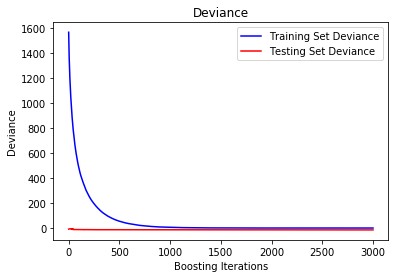

In [233]:
# Deviance plot is to judge whether overfitting or underfitting
test_scores_risk = [0 for _ in range(3000)]
for i, y_pred_risk in enumerate(gb_risk.staged_predict(X_test_fire)):
    test_scores_risk[i] = gb_fnf.loss_(y_test_fire, y_pred_risk)
plt.plot(np.arange(3000)+1, gb_risk.train_score_, 'b-', label='Training Set Deviance')
plt.plot(np.arange(3000)+1, test_scores_risk, 'r-', label='Testing Set Deviance')
plt.title('Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

## MLP

In [142]:
# 'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (45, 45, 45), 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'solver': 'sgd'
mlp_risk = MLPClassifier(hidden_layer_sizes=(45,35,45), activation='tanh',
                         learning_rate='adaptive', learning_rate_init=0.1,
                         alpha=1e-4, solver='sgd', random_state=20)
mlp_risk = mlp_risk.fit(X_train_fire_norm, y_train_fire)

0.3459715639810427
0.7819905213270142


C:\Users\Yi\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [143]:
print(classification_report(y_test_fire*y_pred_gb_fire_bool, y_pred_mlp_risk*y_pred_gb_fire_bool))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        35
         1.0       0.44      0.42      0.43        43
         2.0       0.59      0.66      0.62        50
         3.0       0.50      0.39      0.44        31
         4.0       0.17      0.19      0.18        16
         5.0       0.25      0.50      0.33        10
         6.0       0.50      0.20      0.29        10
         7.0       0.00      0.00      0.00         3
         8.0       0.00      0.00      0.00         4
         9.0       0.00      0.00      0.00         1
        10.0       0.00      0.00      0.00         2
        11.0       0.00      0.00      0.00         1
        12.0       0.00      0.00      0.00         1
        14.0       0.00      0.00      0.00         0
        15.0       0.00      0.00      0.00         1
        16.0       0.00      0.00      0.00         2
        23.0       0.00      0.00      0.00         1

    accuracy              

C:\Users\Yi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Yi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [44]:
@ignore_warnings(category=ConvergenceWarning)
param_grid = {'hidden_layer_sizes': [(45,45,45), (45,90,45), (45,)],
              'activation': ['logistic','tanh', 'relu'],
              'solver': ['sgd', 'adam'],
              'alpha': [1e-4, 0.05],
              'learning_rate': ['constant','adaptive'],
              'learning_rate_init': [.5, .1, .05]}
mlp = MLPClassifier()
gs_cv = GridSearchCV(mlp, param_grid, cv=5).fit(X_train_fire_norm, y_train_fire)
# Pinrt out the best parameters
print(gs_cv.best_params_)

C:\Users\Yi\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Yi\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Yi\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Yi\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_i

C:\Users\Yi\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Yi\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Yi\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Yi\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


C:\Users\Yi\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Yi\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Yi\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Yi\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


C:\Users\Yi\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Yi\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Yi\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Yi\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


C:\Users\Yi\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Yi\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Yi\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Yi\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


C:\Users\Yi\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Yi\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Yi\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Yi\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


C:\Users\Yi\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Yi\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Yi\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Yi\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


C:\Users\Yi\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Yi\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Yi\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Yi\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


C:\Users\Yi\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Yi\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Yi\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Yi\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


C:\Users\Yi\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Yi\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Yi\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Yi\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


C:\Users\Yi\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Yi\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Yi\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Yi\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


C:\Users\Yi\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Yi\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Yi\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Yi\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (45, 45, 45), 'learning_rate': 'adaptive', 'learning_rate_init': 0.1, 'solver': 'sgd'}


C:\Users\Yi\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


## K-Neighbors

In [149]:
neigh = KNeighborsClassifier(n_neighbors=30)
neigh.fit(X_train_fire, y_train_fire) 

y_pred_neigh_risk = neigh.predict(X_test_fire)
print(np.mean((y_test_fire == y_pred_neigh_risk) * y_pred_gb_fire_bool))
#np.mean(result)
result = []
for i, true_val in enumerate(y_test_fire):
    if abs(true_val - y_pred_fire_risk[i]) < 6:
        result.append(1)
    else:
        result.append(0)
print(np.mean(result * y_pred_gb_fire_bool))

0.27488151658767773
0.7725118483412322


In [150]:
print(classification_report(y_test_fire*y_pred_gb_fire_bool, y_pred_neigh_risk*y_pred_gb_fire_bool))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        35
         1.0       0.25      0.33      0.28        43
         2.0       0.42      0.70      0.52        50
         3.0       0.33      0.23      0.27        31
         4.0       0.20      0.06      0.10        16
         5.0       0.10      0.10      0.10        10
         6.0       0.00      0.00      0.00        10
         7.0       0.00      0.00      0.00         3
         8.0       0.00      0.00      0.00         4
         9.0       0.00      0.00      0.00         1
        10.0       0.00      0.00      0.00         2
        11.0       0.00      0.00      0.00         1
        12.0       0.00      0.00      0.00         1
        15.0       0.00      0.00      0.00         1
        16.0       0.00      0.00      0.00         2
        23.0       0.00      0.00      0.00         1

    accuracy                           0.44       211
   macro avg       0.14   

C:\Users\Yi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [54]:
kernel = 1.0 * RBF(1.0)
gpc = GaussianProcessClassifier(kernel=kernel, random_state=0).fit(X_train_fire_norm, y_train_fire)

0.3080568720379147
0.7156398104265402


In [151]:
y_pred_gpc_risk = gpc.predict(X_test_fire_norm)
print(np.mean((y_test_fire == y_pred_gpc_risk) * y_pred_gb_fire_bool))
#np.mean(result)
result = []
for i, true_val in enumerate(y_test_fire):
    if abs(true_val - y_pred_fire_risk[i]) < 6:
        result.append(1)
    else:
        result.append(0)
print(np.mean(result * y_pred_gb_fire_bool))
print(classification_report(y_test_fire*y_pred_gb_fire_bool, y_pred_gpc_risk*y_pred_gb_fire_bool))

0.3080568720379147
0.7725118483412322
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        35
         1.0       0.28      0.44      0.34        43
         2.0       0.47      0.76      0.58        50
         3.0       0.29      0.16      0.21        31
         4.0       0.00      0.00      0.00        16
         5.0       0.43      0.30      0.35        10
         6.0       0.00      0.00      0.00        10
         7.0       0.00      0.00      0.00         3
         8.0       0.00      0.00      0.00         4
         9.0       0.00      0.00      0.00         1
        10.0       0.00      0.00      0.00         2
        11.0       0.00      0.00      0.00         1
        12.0       0.00      0.00      0.00         1
        15.0       0.00      0.00      0.00         1
        16.0       0.00      0.00      0.00         2
        23.0       0.00      0.00      0.00         1

    accuracy                           0.4

C:\Users\Yi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Fire Risk Importance Distribution

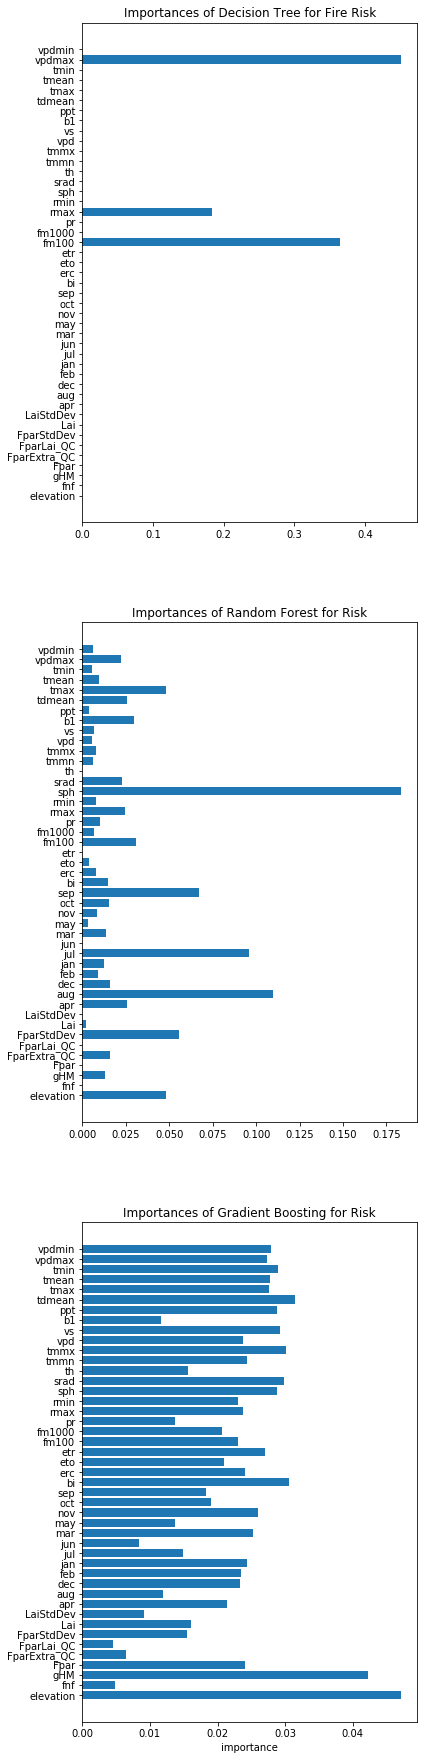

In [119]:
risk_features = samplesCopy.columns
y_pos = np.arange(len(risk_features))

fig = plt.figure()

dt_risk_importances = dt_risk.feature_importances_
ax1 = fig.add_subplot(311)
ax1.barh(y_pos, dt_risk_importances)
ax1.set_yticks(y_pos)
ax1.set_yticklabels(risk_features)
ax1.set_title('Importances of Decision Tree for Fire Risk')

rf_risk_importances = rf_risk.feature_importances_
ax2 = fig.add_subplot(312)
ax2.barh(y_pos, rf_risk_importances)
ax2.set_yticks(y_pos)
ax2.set_yticklabels(risk_features)
ax2.set_title('Importances of Random Forest for Risk')

gb_risk_importances = gb_risk.feature_importances_
ax3 = fig.add_subplot(313)
ax3.barh(y_pos, gb_risk_importances)
ax3.set_yticks(y_pos)
ax3.set_yticklabels(risk_features)
ax3.set_title('Importances of Gradient Boosting for Risk')
ax3.set(xlabel='importance')


plt.subplots_adjust(bottom=.1, top=6)
plt.show()

## Fire Risk Partial Dependencies

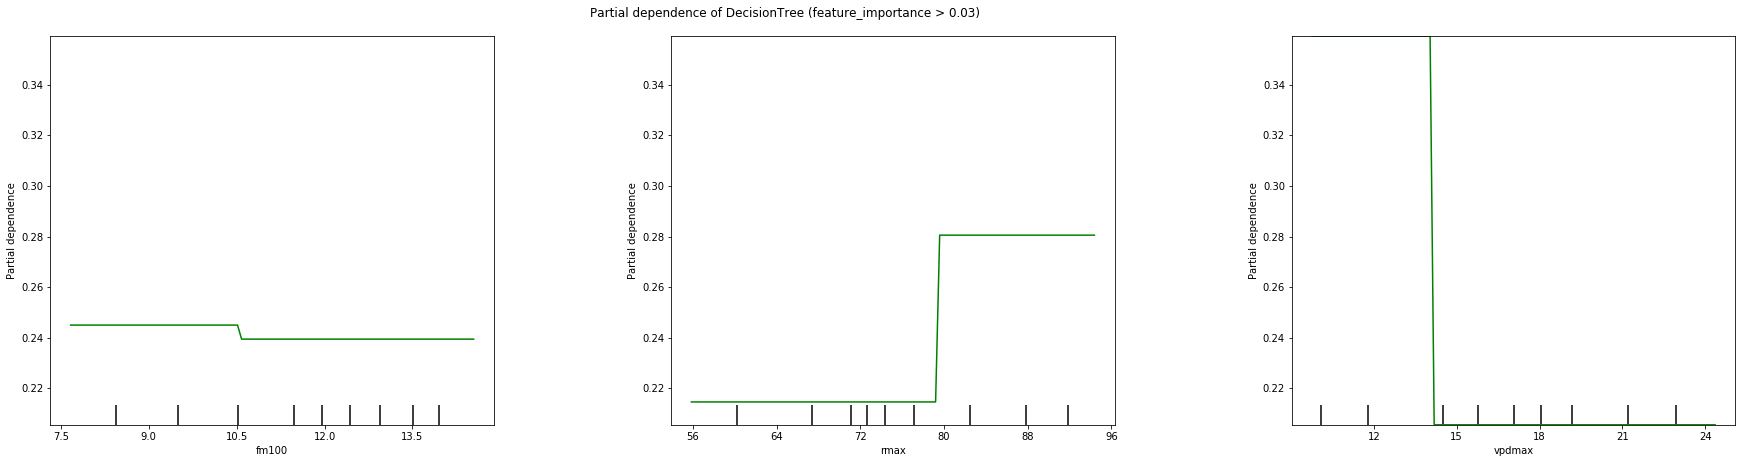

In [141]:
plot_partial_dependence(dt_risk, X=X_train_fire, features=[25, 28, 43], target=3, feature_names=fnf_features, n_jobs=-1)
fig = plt.gcf()
fig.suptitle('Partial dependence of DecisionTree (feature_importance > 0.1, target=3)', x=1.8, y=1.6)
plt.subplots_adjust(top=1.5, right=4)

(array([57., 60., 35., 17., 13., 10.,  3.,  5.,  1.,  3.,  2.,  1.,  0.,
         0.,  1.,  2.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23.]),
 <a list of 22 Patch objects>)

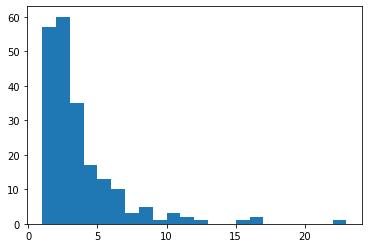

In [158]:
#plt.hist(y_train_fire, bins=np.arange(min(y_train_fire), max(y_train_fire)+1), align='mid')
#plt.hist(y_pred_fire_risk, bins=np.arange(min(y_pred_fire_risk), max(y_pred_fire_risk)+1), align='mid')
plt.hist(y_test_fire, bins=np.arange(min(y_test_fire), max(y_test_fire)+1), align='mid')

(array([71., 65., 28., 18., 16.,  5.,  1.,  2.,  1.,  1.,  0.,  0.,  0.,
         1.,  1.,  0.,  0.,  1.]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19.]),
 <a list of 18 Patch objects>)

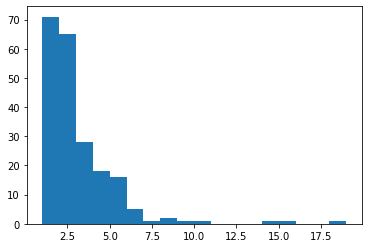

In [159]:
#plt.hist(y_train_fire, bins=np.arange(min(y_train_fire), max(y_train_fire)+1), align='mid')
plt.hist(y_pred_fire_risk, bins=np.arange(min(y_pred_fire_risk), max(y_pred_fire_risk)+1), align='mid')
#plt.hist(y_test_fire, bins=np.arange(min(y_test_fire), max(y_test_fire)+1), align='mid')

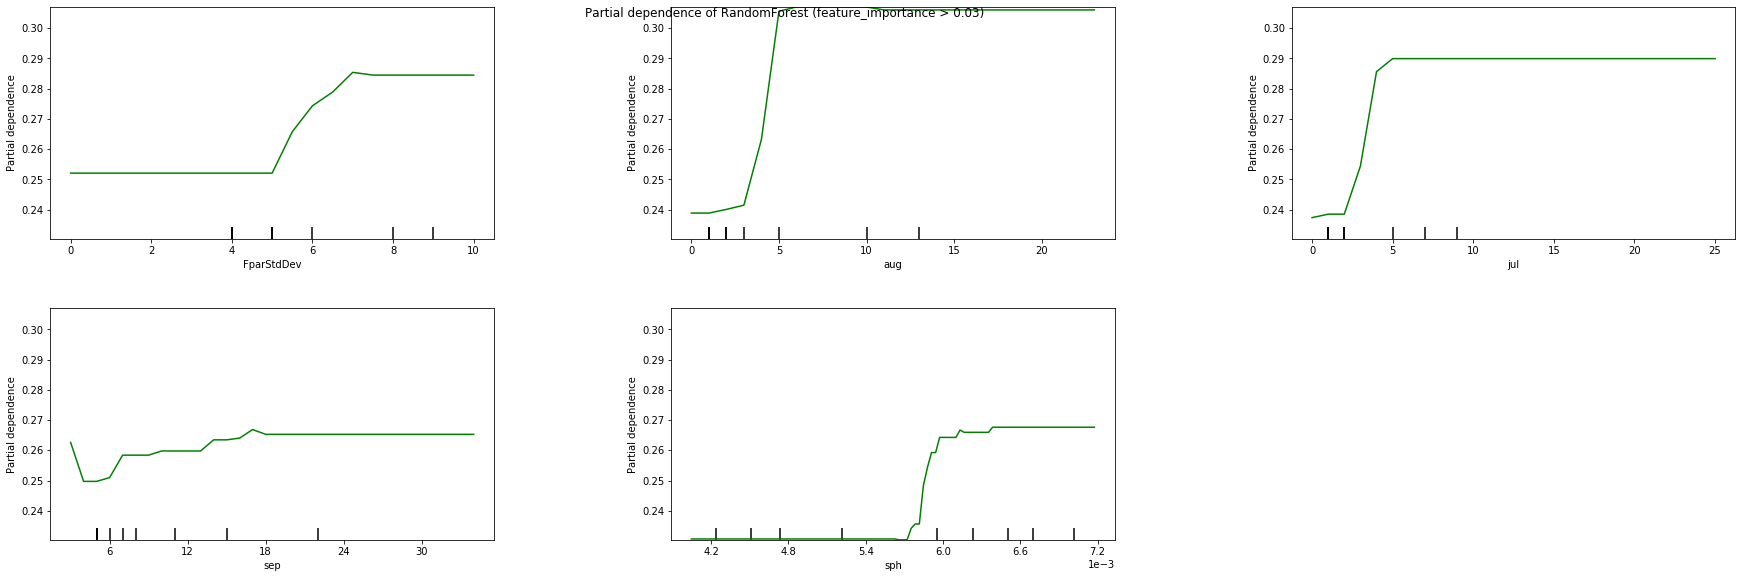

In [145]:
plot_partial_dependence(rf_risk, X=X_train_fire, features=[6, 10, 14, 20, 30], target=3, feature_names=fnf_features, n_jobs=-1)
fig = plt.gcf()
fig.suptitle('Partial dependence of RandomForest (feature_importance > 0.04, target=3)', x=1.8, y=2.1)
plt.subplots_adjust(top=2, right=4)

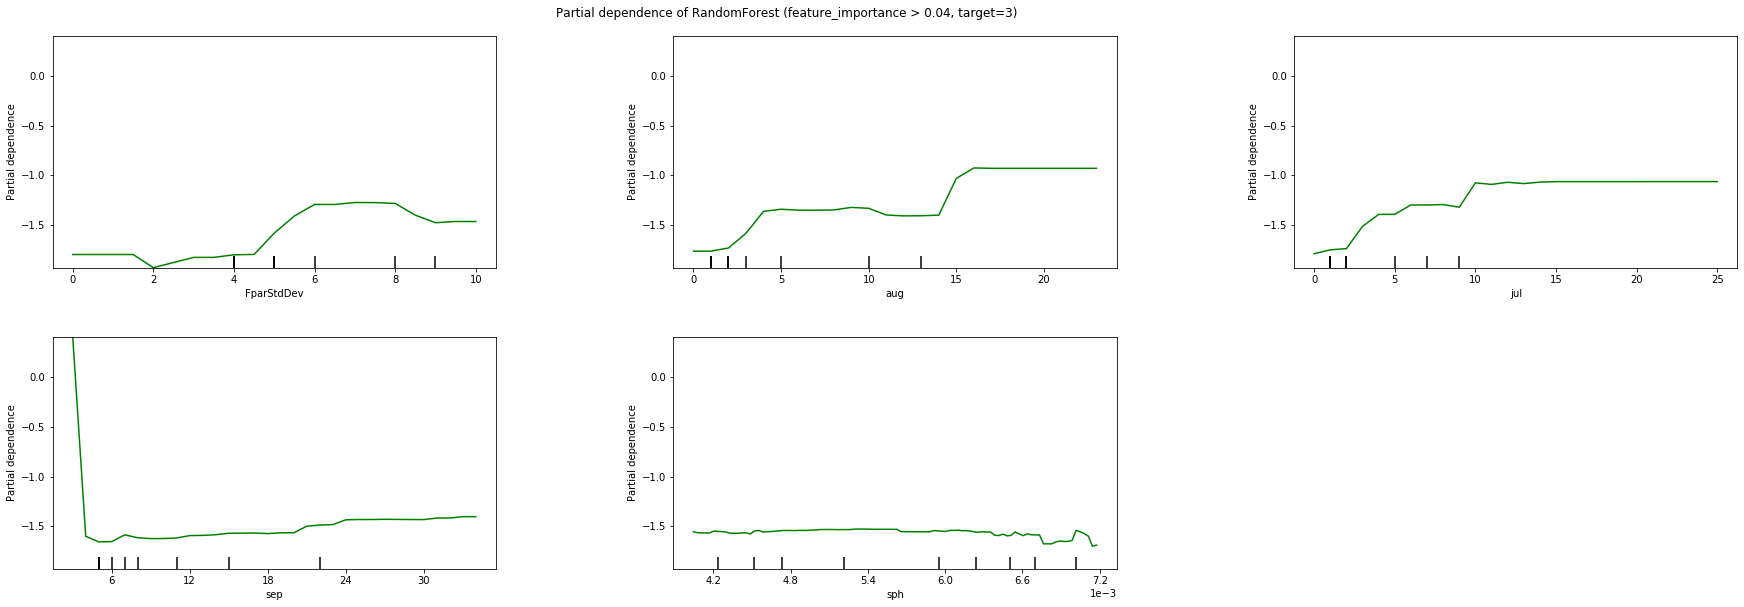

In [149]:
plot_partial_dependence(gb_risk, X=X_train_fire, features=[6, 10, 14, 20, 30], target=3, feature_names=fnf_features, n_jobs=-1)
fig = plt.gcf()
fig.suptitle('Partial dependence of RandomForest (feature_importance > 0.03, target=3)', x=1.8, y=2.1)
plt.subplots_adjust(top=2, right=4)

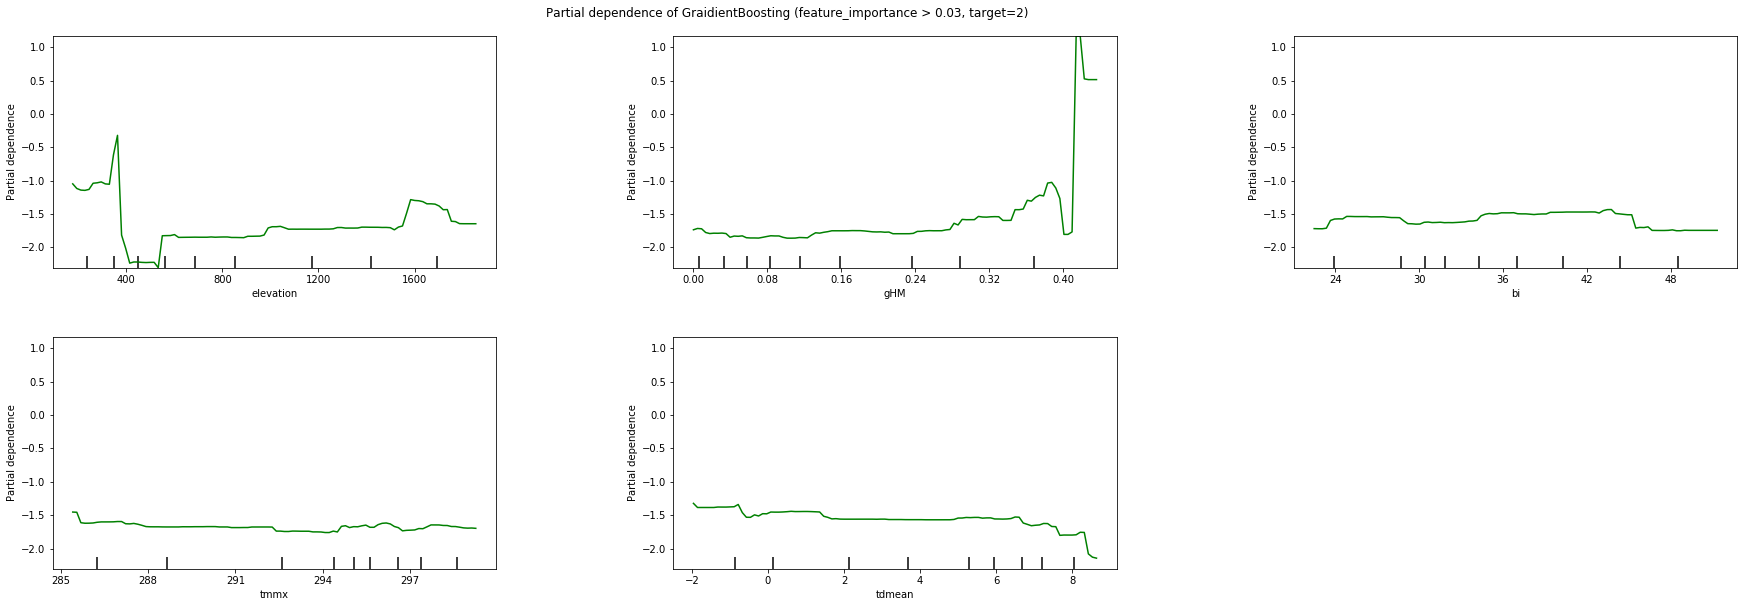

In [148]:
plot_partial_dependence(gb_risk, X=X_train_fire, features=[0, 2, 21, 34, 39], target=2, feature_names=fnf_features, n_jobs=-1)
fig = plt.gcf()
fig.suptitle('Partial dependence of GraidientBoosting (feature_importance > 0.03, target=2)', x=1.8, y=2.1)
plt.subplots_adjust(top=2, right=4)

In [146]:
ws = list(zip(samplesCopy.columns, gb_risk.feature_importances_))
ws
for i, _ in enumerate(ws):
    if _[1] > 0.03:
        print(i)

0
2
21
34
39


# Confusion Matrix for Multi-Classification

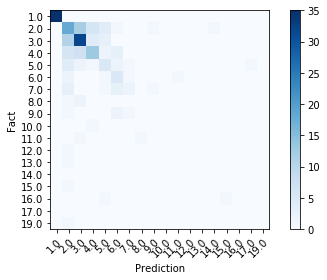

In [184]:
y_test_multi = y_test_fire * y_pred_fire_bool
y_pred_multi = y_pred_fire_risk * y_pred_fire_bool
cm = confusion_matrix(y_test_multi, y_pred_multi)

# Only uses the labels that appear in the data
labels = unique_labels(fireUncertain)


fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), # ... and label them with the respective list entries
       xticklabels=labels, yticklabels=labels,
       xlabel='Prediction', ylabel='Fact',
      )#xlim=[0.0, 40.0], ylim=[40.0, 0.0])
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
fig.tight_layout()

# Metrics

In [120]:
print(classification_report(yy_test, yy_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     71584
           1       0.22      0.75      0.34       211

    accuracy                           0.99     71795
   macro avg       0.61      0.87      0.67     71795
weighted avg       1.00      0.99      0.99     71795

